# BC5 Pipeline

#### &rarr; Goal: Detect occupancy patterns of office zones based on sensor data. Use the trained model, rather than a fixed schedule, to optimise the energy efficiency of HVAC devices.

#### &rarr; General process:

- Identify a model for the occupancy pattern of office zones based on activity data.

- Plug the model into a smart algorithm that controls HVAC devices to improve the decision making process.

- Use the model to predict the occupancy for the coming hours taking into account country holidays and historical occupancy data.

#### &rarr; AI-toolbox usage: identification of a model to predict the occupancy pattern of a zone.



### 0. Import initial libraries
Here we will use the sklearn extension for intel processors to speed up the training phase

In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import numpy as np
import pandas_bokeh
import json

pandas_bokeh.output_notebook()
#pd.set_option('plotting.backend', 'pandas_bokeh')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Loading BokehJS ...

### 1. Read the harmonized time series in json format

#### - Define directories where the json and rdf files are located

In [2]:
from os import getcwd
from os.path import join

dataset_dir = join(getcwd(), "static_data")
ts_filename = join(dataset_dir, "occupancy_timeseries.json")
rdf_filename = join(dataset_dir, "timeseries_metadata.ttl")



#### - Visualize fake RDF as a Graph

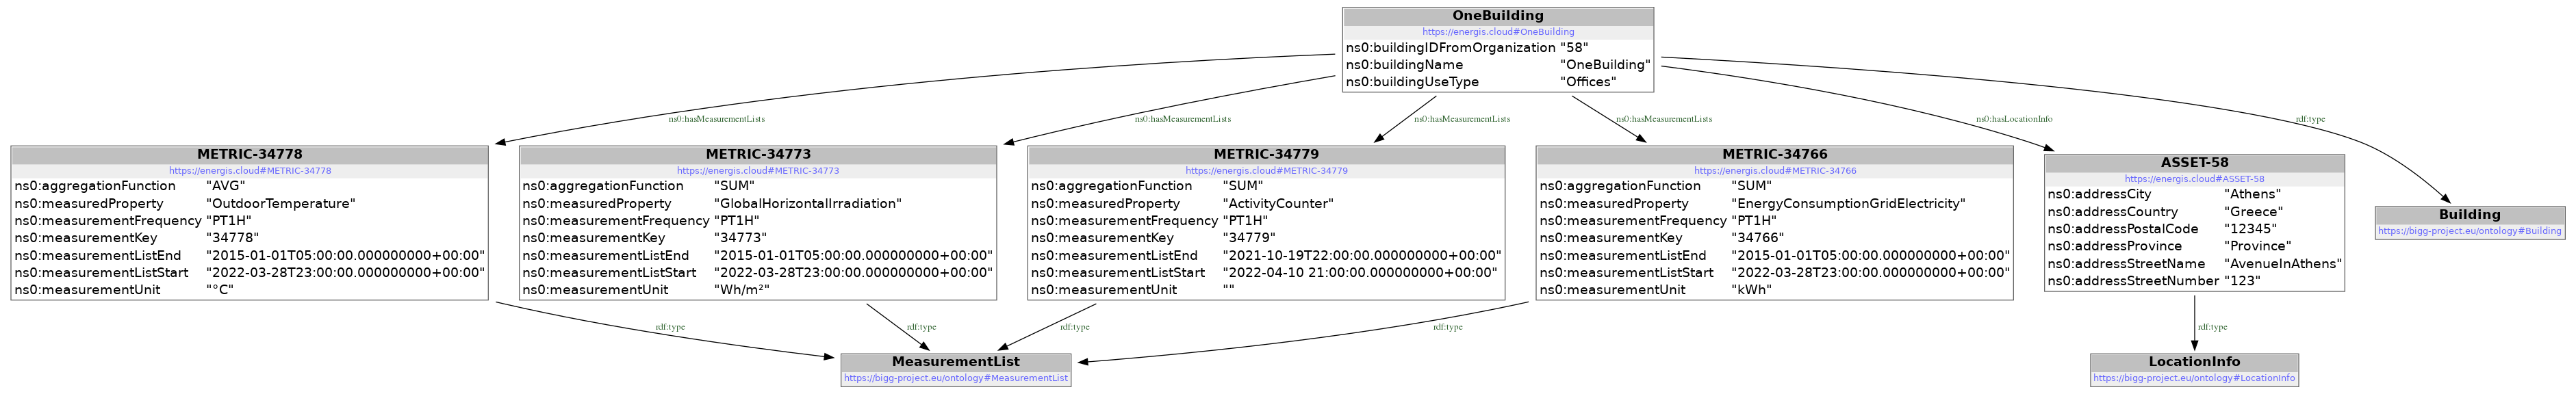

In [3]:
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from rdflib import Graph, Namespace, URIRef, Literal

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))
    
g = Graph()
g.parse(rdf_filename, format="ttl")
visualize(g)

#### - Convert the json loaded from file to a pandas dataframe and extract the name and aggregation functions of the time series from the rdf file

In [4]:
def get_aggregation(function: str) -> str:
        if function.lower() in ['avg', 'average']:
            return 'mean'
        else: 
            return function.lower()

def harmonized_dict_to_dataframe(data: dict, graph: Graph, ontology: str='https://bigg-project.eu/ontology#') -> (pd.DataFrame, dict):
    
    df_list = []
    agg_functions = {}
    namespace_ontology = Namespace(ontology)
    
    for name, time_series in data.items():
        measurement_list = graph.value(None, namespace_ontology['measurementKey'], Literal(name))
        if measurement_list is not None:
            measured_property = str(graph.value(measurement_list, namespace_ontology['measuredProperty'], None))
            agg_function = str(graph.value(measurement_list, namespace_ontology['aggregationFunction'], None))
            agg_functions[measured_property] = get_aggregation(agg_function)
        else:
            measured_property = name
        df_temp = pd.DataFrame.from_records(
                        time_series,
                        columns=["measurementStart", "value"]).rename(columns={"measurementStart": "timestamp", "value": measured_property})
        df_temp["timestamp"] = pd.to_datetime(
                    df_temp["timestamp"],
                    infer_datetime_format=True)
        df_temp.set_index('timestamp', inplace=True)
        df_list.append(df_temp)
        
    return pd.concat(df_list, axis=1), agg_functions


with open(ts_filename, 'r') as f:
    df, aggregations = harmonized_dict_to_dataframe(data=json.load(f), graph=g)
    
df

,ActivityCounter
timestamp,
2021-10-19 22:00:00+00:00,0.0
2021-10-19 23:00:00+00:00,0.0
2021-10-20 00:00:00+00:00,0.0
2021-10-20 01:00:00+00:00,0.0
2021-10-20 02:00:00+00:00,0.0
...,...
2022-04-10 17:00:00+00:00,23.0
2022-04-10 18:00:00+00:00,5.0
2022-04-10 19:00:00+00:00,0.0


In [5]:
aggregations

{'ActivityCounter': 'sum'}

In [6]:
target = "ActivityCounter"

### 2. Get high-level data description

#### - Get general statistics on the dataframe

In [7]:
df.describe()

,ActivityCounter
count,3940.000000
mean,41.382843
std,63.836633
min,0.000000
25%,0.000000
50%,2.550000
75%,69.000000
max,358.800000


#### - Plot the data as they are

In [8]:

df.plot_bokeh.line(
    x=df.index, 
    y=target,
    figsize=(1200, 600),
    ylim=(0, 700),
    zooming=True,
    panning=True,
    rangetool=True
)

Column(id='1097', ...)

### 3. Clean up the data

#### - Check NaN per column

In [9]:
df.isna().sum(axis = 0)

ActivityCounter    0
dtype: int64

#### - Check duplicated values

In [10]:
df[df.index.duplicated(False)]

,ActivityCounter
timestamp,


#### - Remove duplicates and keep last

In [11]:
df = df[~df.index.duplicated(keep='last')]
df

,ActivityCounter
timestamp,
2021-10-19 22:00:00+00:00,0.0
2021-10-19 23:00:00+00:00,0.0
2021-10-20 00:00:00+00:00,0.0
2021-10-20 01:00:00+00:00,0.0
2021-10-20 02:00:00+00:00,0.0
...,...
2022-04-10 17:00:00+00:00,23.0
2022-04-10 18:00:00+00:00,5.0
2022-04-10 19:00:00+00:00,0.0


#### - Analyse frequencies of data grid with detect_time_step

Here we are lucky that the 3 series have the same frequency. The first is irregular, e.g. with gaps, while the other two are uniform.

In [12]:
from ai_toolbox.data_preparation import detect_time_step, align_time_grid
from pandas.tseries.frequencies import to_offset

list_freq = []
for column in df.columns.to_list():
    print("{}\n".format(detect_time_step(df[column])))
    list_freq.append(detect_time_step(df[column])[0])

('H',                  freq_count freqstr
timedelta                          
0 days 01:00:00        3932       H
0 days 02:00:00           2      2H
0 days 07:00:00           1      7H
0 days 13:00:00           1     13H
1 days 00:00:00           1       D
6 days 18:00:00           1    162H
0 days 09:00:00           1      9H)



#### - Align time grid if necessary

If there are different frequencies in the data grid, get the max time step for the alignment and use the aggregation functions extracted from the rdf. In our case it is not necessary to align the frequecies we have one series but it could be misaligned.

In [13]:
if len(set(list_freq)) > 1:
    print("Data are not at the same frequency.")
else:
    print("All data are at the same frequency but could be misaligned.")

columns_resampled = []
max_freq = max(list_freq, key=to_offset)
df= df.resample(max_freq).agg(aggregations, skipna=False)

All data are at the same frequency but could be misaligned.


#### - Drop NaNs

In [14]:
df.dropna(inplace=True)

#### - Detect outliers for the training phase
Here we want to prepare the data for the training and remove only the most evident outliers.

In [15]:
from sklearn.cluster import DBSCAN

outliers = DBSCAN(min_samples=40, eps=60).fit_predict(df[[target]])
df= df.assign(outliers= df[target].where(outliers < 0))
df[~df.outliers.isna()]

,ActivityCounter,outliers
timestamp,,
2021-10-20 07:00:00+00:00,358.8,358.8


#### - Plot the outliers and the series

In [16]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource
from bokeh.models import  HoverTool

tools_to_show = 'hover,box_zoom,pan,save,reset,wheel_zoom'
cds = ColumnDataSource(df)
p = figure(x_axis_type="datetime", height=600, width=1200, tools=tools_to_show, title= "Activity counter outliers")
p.line(
    x='timestamp',
    y=target,
    source=cds,
    legend_label=target,
    color="#104ca2"
)
p.circle(
    x='timestamp',
    y="outliers",
    source=cds,
    legend_label="outliers",
    color="#4b875f",
    size=8

)
p.legend.click_policy="hide"
hover = p.select(dict(type=HoverTool))
hover.formatters={'@timestamp': 'datetime'}
hover.tooltips = [("consumption", "@"+ target + "{int}"), ("outlier", "@outliers{int}"), ("date", "@timestamp{%F}")]
hover.mode = 'mouse'
show(p)

#### - Remove outliers and drop the column "outliers" used to create the plot

In [17]:
df = df[df.outliers.isna()]
df.drop(columns='outliers', inplace=True)
df.head(20)

,ActivityCounter
timestamp,
2021-10-19 22:00:00+00:00,0.0
2021-10-19 23:00:00+00:00,0.0
2021-10-20 00:00:00+00:00,0.0
2021-10-20 01:00:00+00:00,0.0
2021-10-20 02:00:00+00:00,0.0
2021-10-20 03:00:00+00:00,0.0
2021-10-20 04:00:00+00:00,24.4
2021-10-20 05:00:00+00:00,87.0
2021-10-20 06:00:00+00:00,245.6


### 4. Feature engineering

#### - Create column occupancy_cat for classification

Binning cumulative_activity into 2 (unevenly spaced) bins:
- occupancy_cat = 0 if 0 <= cumulative_activity <= 10 
- occupancy_cat = 1 if cumulative_activity > 1

In [18]:
occupancy_cut = pd.cut(df[target], [0, 10, np.inf], right=True, include_lowest=True, labels=False, retbins=True)
target_cat = 'occupancy_cat'
df[target_cat] = occupancy_cut[0]
df

,ActivityCounter,occupancy_cat
timestamp,,
2021-10-19 22:00:00+00:00,0.0,0
2021-10-19 23:00:00+00:00,0.0,0
2021-10-20 00:00:00+00:00,0.0,0
2021-10-20 01:00:00+00:00,0.0,0
2021-10-20 02:00:00+00:00,0.0,0
...,...,...
2022-04-10 17:00:00+00:00,23.0,1
2022-04-10 18:00:00+00:00,5.0,0
2022-04-10 19:00:00+00:00,0.0,0


#### - Checking balance of classes

In [19]:
df[target_cat].value_counts(normalize=True) * 100


occupancy_cat
0    61.575524
1    38.424476
Name: proportion, dtype: float64

### 4. Modeling

#### - Columns to be used as predictors (X data)
We remove only the y feature, the one that we want to predict based on the predictor features. In this case our X data will be only calendar features extracted from the DatetimeIndex using a sklearn transformer. So the X dataframe will have only the index.

In [20]:
to_remove = [target, target_cat]
predictors = [feature for feature in list(df.columns) if feature not in to_remove]
sorted(predictors)

[]

In [21]:
X = df.loc[:, predictors]
X

""
timestamp
2021-10-19 22:00:00+00:00
2021-10-19 23:00:00+00:00
2021-10-20 00:00:00+00:00
2021-10-20 01:00:00+00:00
2021-10-20 02:00:00+00:00
...
2022-04-10 17:00:00+00:00
2022-04-10 18:00:00+00:00
2022-04-10 19:00:00+00:00


#### - Columns to be used as outcome variable
We also limit the time range of the outcome between the year 2015:2018 (2018 excluded).

In [22]:
y = df.loc[:, target_cat]
y

timestamp
2021-10-19 22:00:00+00:00    0
2021-10-19 23:00:00+00:00    0
2021-10-20 00:00:00+00:00    0
2021-10-20 01:00:00+00:00    0
2021-10-20 02:00:00+00:00    0
                            ..
2022-04-10 17:00:00+00:00    1
2022-04-10 18:00:00+00:00    0
2022-04-10 19:00:00+00:00    0
2022-04-10 20:00:00+00:00    0
2022-04-10 21:00:00+00:00    0
Name: occupancy_cat, Length: 4151, dtype: int64

### - Check the output of the trasfomers used in the pipelines (for demo purposes)

#### - Add Holidays for Greece using column transformer
The holidays are not hardcoded but are automatically generated based on the Country, Province, State, etc...
P.S. We create another df just to check the results of the column transfomer that we will apply later on using sklearn Pipelines. Transformers work with numpy arrays because they are more efficent (sparse matrices, etc...).

In [23]:
from ai_toolbox.data_transformation import HolidayTransformer

df_test = HolidayTransformer(country='GR').fit_transform(X)
df_test

,holiday
timestamp,
2021-10-19 22:00:00+00:00,0
2021-10-19 23:00:00+00:00,0
2021-10-20 00:00:00+00:00,0
2021-10-20 01:00:00+00:00,0
2021-10-20 02:00:00+00:00,0
...,...
2022-04-10 17:00:00+00:00,0
2022-04-10 18:00:00+00:00,0
2022-04-10 19:00:00+00:00,0


#### - Double-check holidays in the time range of the df

In [24]:
df_test[df_test['holiday'] == 1].index.normalize().unique()

DatetimeIndex(['2021-10-28 00:00:00+00:00', '2021-12-25 00:00:00+00:00',
               '2021-12-26 00:00:00+00:00', '2022-01-01 00:00:00+00:00',
               '2022-01-06 00:00:00+00:00', '2022-03-07 00:00:00+00:00',
               '2022-03-25 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', freq=None)

#### - Add calendar components to the dataframe

In [25]:
from ai_toolbox.data_transformation import CalendarComponentTransformer

components = ["weekday", "hour"]
df_test = CalendarComponentTransformer(components=components, encode=True).fit_transform(X)
df_test

,weekday_sin,weekday_cos,hour_sin,hour_cos
timestamp,,,,
2021-10-19 22:00:00+00:00,0.781831,0.623490,-0.500000,8.660254e-01
2021-10-19 23:00:00+00:00,0.781831,0.623490,-0.258819,9.659258e-01
2021-10-20 00:00:00+00:00,0.974928,-0.222521,0.000000,1.000000e+00
2021-10-20 01:00:00+00:00,0.974928,-0.222521,0.258819,9.659258e-01
2021-10-20 02:00:00+00:00,0.974928,-0.222521,0.500000,8.660254e-01
...,...,...,...,...
2022-04-10 17:00:00+00:00,-0.781831,0.623490,-0.965926,-2.588190e-01
2022-04-10 18:00:00+00:00,-0.781831,0.623490,-1.000000,-1.836970e-16
2022-04-10 19:00:00+00:00,-0.781831,0.623490,-0.965926,2.588190e-01


#### - Nested CV optimization framework
We want to find the best performing pipeline from the initial grid of pipelines and parameters using nested CV.

In [26]:
from ai_toolbox.data_modelling import identify_best_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from math import sqrt, ceil
from sklearn.pipeline import Pipeline
from time import time
import numpy as np

cv_splitter_outer = TimeSeriesSplit(n_splits=5)
cv_splitter_inner = TimeSeriesSplit(n_splits=3)
n_features = len(predictors) + len(components) + 1

grid = {
    Pipeline([
        ('holidays', HolidayTransformer(country='GR')),
        ('calendar', CalendarComponentTransformer(components=components, encode=False)), 
        ('model',  RandomForestClassifier())
    ]
    ):
    {
        'model__n_estimators': [10, 100],
        'model__max_features': np.linspace(ceil(sqrt(n_features)), n_features, 3, dtype=int) 
    },
    Pipeline([
        ('holidays', HolidayTransformer(country='GR')),
        ('calendar', CalendarComponentTransformer(components=components, encode=True)), 
        ('model', SVC(cache_size=2000))
    ]
    ):
    {
        'model__C': [0.1, 1, 10],
    },
    Pipeline([
        ('holidays', HolidayTransformer(country='GR')),
        ('calendar', CalendarComponentTransformer(components=components, encode=True)), 
        ('model', LogisticRegression())
    ]
    ):
    {
        'model__C': [0.1, 1, 10],
    }
}
grid2 = {
    Pipeline([
        ('holidays', HolidayTransformer(country='GR')),
        ('calendar', CalendarComponentTransformer(components=components, encode=True)), 
        ('model', SVC(cache_size=2000))
    ]
    ):
    {
        'model__C': [0.1, 1, 10],
    },
    Pipeline([
        ('holidays', HolidayTransformer(country='GR')),
        ('calendar', CalendarComponentTransformer(components=components, encode=True)), 
        ('model', LogisticRegression())
    ]
    ):
    {
        'model__C': [0.1, 1, 10],
    }
}
start_time = time()
results = identify_best_model(
    X_data=X,
    y_data=y,
    model_families_parameter_grid=grid2,
    cv_inner=cv_splitter_inner,
    cv_outer=cv_splitter_outer,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    compare_with='accuracy'
)

print("Best model: {}".format(results[0]))
print("Best parameters: {}".format(results[1]))
print("Mean score: {}".format(results[2]))
print("Std score: {}".format(results[3]))
print("Evaluation results: {}".format(results[5]))

print("Time to identify best model: {} seconds.".format(time()-start_time))

Best model: Pipeline(steps=[('holidays', HolidayTransformer(country='GR')),
                ('calendar',
                 CalendarComponentTransformer(components=['weekday', 'hour'],
                                              encode=True)),
                ('model', SVC(C=10, cache_size=2000))])
Best parameters: {'model__C': 10}
Mean score: 0.9065123010130245
Std score: 0.030184678030642415
Evaluation results: {'SVC(cache_size=2000)': {'test_accuracy': {'mean': 0.9065123010130245, 'std': 0.030184678030642415}, 'test_precision': {'mean': 0.8622671815945788, 'std': 0.09793269738196957}, 'test_recall': {'mean': 0.9062421016658305, 'std': 0.06613909987327038}, 'test_f1': {'mean': 0.877700148516942, 'std': 0.04561867483666317}}, 'LogisticRegression()': {'test_accuracy': {'mean': 0.8448625180897251, 'std': 0.026231872788126664}, 'test_precision': {'mean': 0.7937269508123634, 'std': 0.09633483448670975}, 'test_recall': {'mean': 0.8043118087821478, 'std': 0.04492374421048581}, 'test_f1': {'

In [27]:
pd.DataFrame.from_dict(results[5])

,SVC(cache_size=2000),LogisticRegression()
test_accuracy,"{'mean': 0.9065123010130245, 'std': 0.03018467...","{'mean': 0.8448625180897251, 'std': 0.02623187..."
test_precision,"{'mean': 0.8622671815945788, 'std': 0.09793269...","{'mean': 0.7937269508123634, 'std': 0.09633483..."
test_recall,"{'mean': 0.9062421016658305, 'std': 0.06613909...","{'mean': 0.8043118087821478, 'std': 0.04492374..."
test_f1,"{'mean': 0.877700148516942, 'std': 0.045618674...","{'mean': 0.7944142649119794, 'std': 0.04704833..."


In [28]:
pd.DataFrame.from_dict(results[4])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.256799,0.149193,0.020065,0.013420,0.1,{'model__C': 0.1},0.947927,0.916104,0.864995,0.909675,0.034160,2
1,0.270053,0.118271,0.018970,0.011304,1,{'model__C': 1},0.951784,0.909354,0.857281,0.906140,0.038648,3
2,0.283679,0.092251,0.017093,0.006710,10,{'model__C': 10},0.951784,0.924783,0.862102,0.912890,0.037566,1


In [29]:
best_model = results[0]
best_model

Pipeline(steps=[('holidays', HolidayTransformer(country='GR')),
                ('calendar',
                 CalendarComponentTransformer(components=['weekday', 'hour'],
                                              encode=True)),
                ('model', SVC(C=10, cache_size=2000))])

### - Check predictions
Here we also add the holiday column to the final Dataframe just to be able to show the holidays on the plot and verify that our model understood from the few training data
that during holidays we should not have occupancy.

In [30]:
df["y_pred"] = best_model.predict(df[predictors])
df["holiday"] = HolidayTransformer(country='GR').fit_transform(X)

In [31]:
f = df.plot_bokeh.area(
    title = "Occupancy Forecast",
    x=df.index, 
    y=[target_cat, "y_pred", "holiday"],
    figsize=(1200, 600),
    ylim=(0, 1.1),
    zooming=True,
    panning=True
)


### 6. Model serialization
We will serialize the best performing pipeline and store it on the disk.

In [33]:
from ai_toolbox.data_modelling import serialize_model

model_filename = "best_pipeline_bc5"

model_full_path = serialize_model(best_model, join(dataset_dir, model_filename), 'cloudpickle')
model_full_path

'/home/rick/Coding/Notebooks/BIGG/static_data/best_pipeline_bc5.cloudpickle'